# Modeling and Simulation in Python

Chapter 9 Example: Bungee jumping

Copyright 2017 Allen Downey

License: [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0)


In [1]:
# If you want the figures to appear in the notebook, 
# and you want to interact with them, use
# %matplotlib notebook

# If you want the figures to appear in the notebook, 
# and you don't want to interact with them, use
# %matplotlib inline

# If you want the figures to appear in separate windows, use
# %matplotlib qt5

# tempo switch from one to another, you have to select Kernel->Restart

%matplotlib inline

from modsim import *


I'll start by getting the units we'll need from Pint.

In [2]:
m = UNITS.meter
s = UNITS.second
kg = UNITS.kilogram
N = UNITS.newton

### Dropping people

We'll develop a model of a person bungee jumping from the top of the Empire State Building.  Let's assume that the bungee cord hangs from a crane that's far enough from the side of the building.

First I'll create a `Condition` object to contain the quantities we'll need.  They are the same as in Chapter 9, except:

1. I'll assume the person is 75 kg.

2. With a terminal velocity of 60 m/s.

3. The length of the bungee cord is 100 m.

4. The spring constant of the cord is 20 N / m when the cord is stretched, and 0 when it's compressed.

In [3]:
condition = Condition(height = 381 * m,
                      v_init = 0 * m / s,
                      g = 9.8 * m/s**2,
                      mass = 75 * kg,
                      area = 1 * m**2,
                      rho = 1.2 * kg/m**3,
                      v_term = 60 * m / s,
                      duration = 12 * s,
                      length = 100 * m,
                      k = 20 * N / m)

Now here's a version of `make_system` that takes a `Condition` object as a parameter.

`make_system` uses the given value of `v_term` to compute the drag coefficient `C_d`.

In [4]:
def make_system(condition):
    """Makes a System object for the given conditions.
    
    condition: Condition with height, g, mass, diameter, 
               rho, v_term, and duration
    
    returns: System with init, g, mass, rho, C_d, area, and ts
    """
    unpack(condition)
    
    init = State(y=height, v=v_init)
    C_d = 2 * mass * g / (rho * area * v_term**2)
    ts = linspace(0, duration, 101)
    
    return System(init=init, g=g, mass=mass, rho=rho,
                  C_d=C_d, area=area, length=length,
                  y_attach=height, k=k, ts=ts)

Let's make a `System`

In [7]:
system = make_system(condition)
system

,value
init,y 381 meter v 0.0 meter / secon...
g,9.8 meter / second ** 2
mass,75 kilogram
rho,1.2 kilogram / meter ** 3
C_d,0.3402777777777778 dimensionless
area,1 meter ** 2
length,100 meter
y_attach,381 meter
k,20.0 newton / meter
ts,"[0.0 second, 0.12 second, 0.24 second, 0.36 se..."


### Phase 1

We'll divide the simulation into two phases:

1.  The initial drop, until the bungee cord is fully extended.  During this phase, we ignore the effect of the cord.

2.  After the cord is extended, it behaves like a spring, applying an upward force on the jumper.

Here's the slope function, including acceleration due to gravity and drag.  We'll use this for Phase 1, before the cord starts stretching.

In [8]:
def slope_func(state, t, system):
    """Compute derivatives of the state.
    
    state: position, velocity
    t: time
    system: System object containing g, rho,
            C_d, area, and mass
    
    returns: derivatives of y and v
    """
    y, v = state
    unpack(system)
    
    f_drag = rho * v**2 * C_d * area / 2
    a_drag = f_drag / mass
    
    dydt = v
    dvdt = -g + a_drag
    
    return dydt, dvdt

As always, let's test the slope function with the initial conditions.

In [9]:
slope_func(system.init, 0, system)

(<Quantity(0.0, 'meter / second')>, <Quantity(-9.8, 'meter / second ** 2')>)

And then run the simulation.

In [10]:
run_odeint(system, slope_func)

First check that the simulation ran long enough to extend the cord.

In [11]:
def final_state(results):
    """Returns the final position and velocity, with units.
    
    results: TimeFrame with y and v.
    
    returns: y, v at t_end
    """
    t_end = results.index[-1]
    y, v = results.loc[t_end]
    return y*m, v*m/s

In [12]:
final_state(system.results)

(<Quantity(-91.59169998040457, 'meter')>,
 <Quantity(-57.665389726001294, 'meter / second')>)

Then compute the time until the height of the jumper is 281 m (the initial height minus the length of the cord).

In [13]:
y = system.results.y
inverse = Series(y.index, index=y.values)
T = interpolate(inverse, kind='cubic')
T_phase1 = T(281)
T_phase1

array(4.725017378668564)

Setting the duration to the computed flight time, we can check the final conditions.

In [14]:
condition.set(duration=T_phase1)
system = make_system(condition)
run_odeint(system, slope_func)
y_final, v_final = final_state(system.results)

The final height is close to 0, as expected.  And the final velocity is close to the given terminal velocity.

In [15]:
y_final, v_final

(<Quantity(280.99999831911003, 'meter')>,
 <Quantity(-38.876852797029045, 'meter / second')>)

Here's the plot of position as a function of time.

In [16]:
def plot_position(results):
    """Plot the results.
    
    results: DataFrame with position, `y`
    """
    newfig()
    plot(results.y, label='y')
        
    decorate(xlabel='Time (s)',
             ylabel='Position (m)')

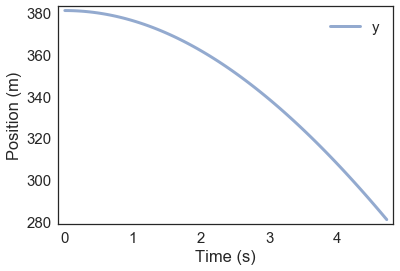

In [17]:
plot_position(system.results)

And velocity as a function of time:

In [18]:
def plot_velocity(results):
    """Plot the results.
    
    results: DataFrame with velocity, v
    """
    newfig()
    plot(results.v, label='v')
        
    decorate(xlabel='Time (s)',
             ylabel='Velocity (m/2)')

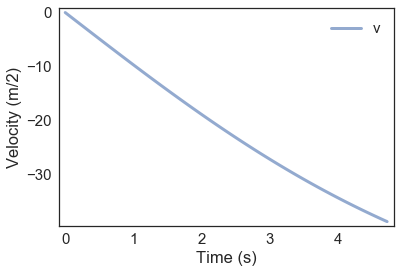

In [19]:
plot_velocity(system.results)

### Phase 2

So far everything is the same as in Chapter 9.

Now we need a new `System` object, `system2`, where

1. The initial State of `system2` is the final state of `system1`.

2. The timesteps, `system2.ts`, pick up where `system.ts` left off.

It might be better to write a new make_system function, but to keep it simple, I just called `make_system` again and then changed `init` and `ts`.

In [20]:
system2 = make_system(condition)
system2.init = State(y=y_final, v=v_final)
system2.ts = linspace(T_phase1, T_phase1+9, 101)

system2

,value
init,y 280.99999831911003 meter v -...
g,9.8 meter / second ** 2
mass,75 kilogram
rho,1.2 kilogram / meter ** 3
C_d,0.3402777777777778 dimensionless
area,1 meter ** 2
length,100 meter
y_attach,381 meter
k,20.0 newton / meter
ts,"[4.72501737867, 4.81501737867, 4.90501737867, ..."


In [21]:
system2.init

,value
y,280.99999831911003 meter
v,-38.876852797029045 meter / second


Here's the new slope function that includes the spring force.

Notice that it also uses `np.sign` to make sure the drag force points in the right direction!

In [22]:
def spring_force(y, y_attach, length, k):
    zero_point = y_attach - length
    offset = y - zero_point
    f_spring = -k * offset
    return f_spring

In [23]:
def slope_func(state, t, system):
    """Compute derivatives of the state.
    
    state: position, velocity
    t: time
    system: System object containing g, rho,
            C_d, area, and mass
    
    returns: derivatives of y and v
    """
    y, v = state
    unpack(system)
    
    f_drag = -np.sign(v) * rho * v**2 * C_d * area / 2
    a_drag = f_drag / mass
    
    drop = init.y - y
    f_spring = spring_force(y, y_attach, length, k)
    a_spring = f_spring / mass
    
    dvdt = -g + a_drag + a_spring
    
    return v, dvdt

As always, let's test the slope function with the initial conditions.

In [24]:
slope_func(system.init, 0, system2)

(<Quantity(0.0, 'meter / second')>,
 <Quantity(-36.46666666666667, 'meter / second ** 2')>)

And then run the simulation.

In [25]:
run_odeint(system2, slope_func)

First check that the simulation ran long enough for the penny to land.

In [26]:
final_state(system2.results)

(<Quantity(291.8235609877133, 'meter')>,
 <Quantity(13.425241215041797, 'meter / second')>)

Here's the plot of position as a function of time.

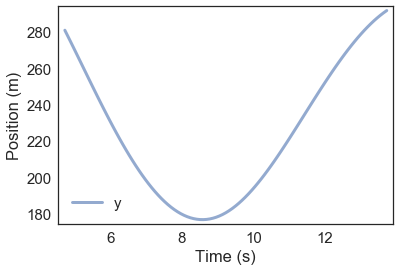

In [27]:
plot_position(system2.results)

And velocity as a function of time:

In [28]:
def plot_velocity(results):
    """Plot the results.
    
    results: DataFrame with velocity, v
    """
    newfig()
    plot(results.v, label='v')
        
    decorate(xlabel='Time (s)',
             ylabel='Velocity (m/s)')

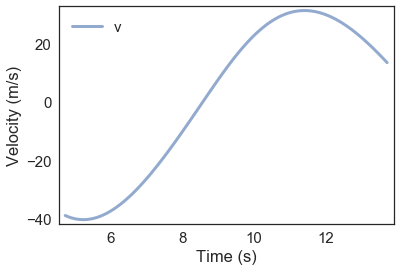

In [29]:
plot_velocity(system2.results)

Finally, we can plot Phase 1 and Phase 2 on the same axes:

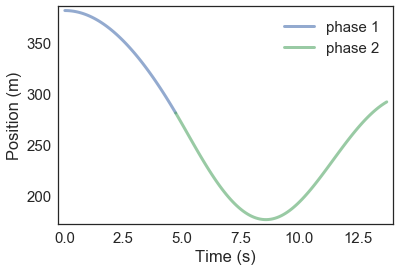

In [30]:
plot(system.results.y, label='phase 1')
plot(system2.results.y, label='phase 2')
        
decorate(xlabel='Time (s)',
         ylabel='Position (m)')

**Exercise:** Sometimes you can avoid breaking a simulation into phases if you can write one slope function that works across multiple phases.  In this case, you can.

Modify the second slope function so that it includes the effect of the spring if the spring force acts upward, and ignores it otherwise (because the bungee cord goes slack when it is compressed).  Run the simulation through Phases 1 and 2.

In [ ]:
def slope_func(state, t, system):
    """Compute derivatives of the state.
    
    state: position, velocity
    t: time
    system: System object containing g, rho,
            C_d, area, and mass
    
    returns: derivatives of y and v
    """
    y, v = state
    unpack(system)
    
    f_drag = -np.sign(v) * rho * v**2 * C_d * area / 2
    a_drag = f_drag / mass
    
    drop = init.y - y
    f_spring = spring_force(y, y_attach, length, k)
    a_spring = f_spring / mass
    
    dvdt = -g + a_drag + a_spring
    
    return v, dvdt